In [1]:
from google.colab import files

uploaded = files.upload()


Saving Assignment_Data 1 (1).xlsx to Assignment_Data 1 (1).xlsx


Shape (rows, cols): (200, 9)
Columns: ['patient_id', 'age', 'gender', 'diagnosis_code', 'num_previous_admissions', 'medication_type', 'length_of_stay', 'readmitted_30_days', 'discharge_note']

Number of Missing Values:
patient_id                 0
age                        0
gender                     0
diagnosis_code             0
num_previous_admissions    0
medication_type            0
length_of_stay             0
readmitted_30_days         0
discharge_note             0
dtype: int64

Make sure patient_id are actually unique:
Unique patient_id: 200
Total rows: 200

Target distribution
readmitted_30_days
0    135
1     65
Name: count, dtype: int64
Readmission rate: 0.3250 (32.50%)


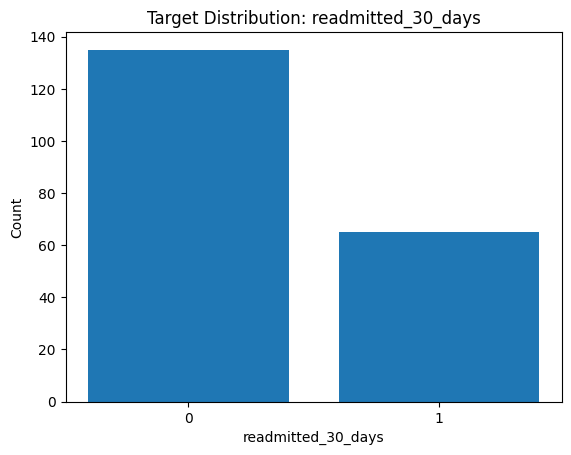


Numeric Columns summary:
                         count     mean        std   min    25%    50%  \
patient_id               200.0  100.500  57.879185   1.0  50.75  100.5   
age                      200.0   53.720  21.294574  20.0  34.00   54.0   
num_previous_admissions  200.0    1.600   1.310951   0.0   1.00    1.0   
length_of_stay           200.0    7.865   4.134276   1.0   4.00    8.0   
readmitted_30_days       200.0    0.325   0.469550   0.0   0.00    0.0   

                            75%    max  
patient_id               150.25  200.0  
age                       73.00   89.0  
num_previous_admissions    2.00    6.0  
length_of_stay            11.00   14.0  
readmitted_30_days         1.00    1.0  


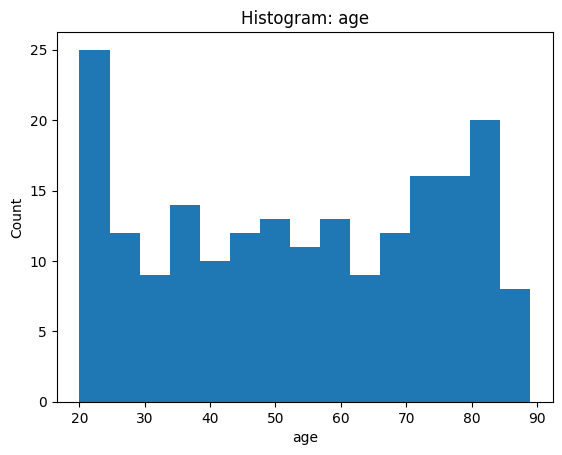

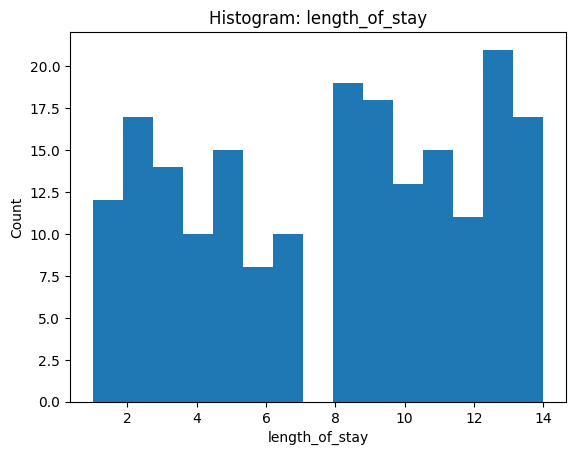

/tmp/ipython-input-2858911875.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=[f"{TARGET_COL}={k}" for k in sorted(df[TARGET_COL].unique())])


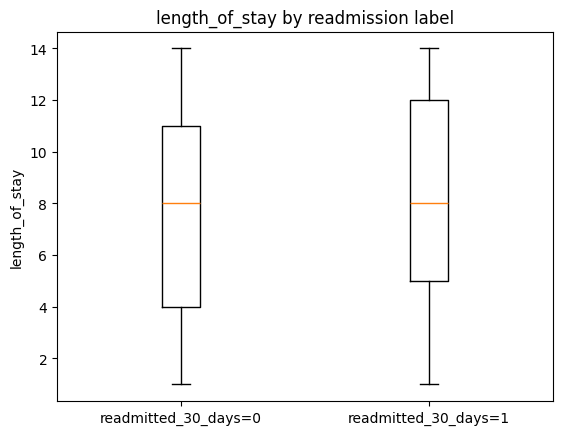


diagnosis_code: Value Counts
diagnosis_code
D001    56
D002    54
D004    53
D003    37
Name: count, dtype: int64

medication_type: Value Counts
medication_type
Type B    69
Type A    67
Type C    64
Name: count, dtype: int64

diagnosis_code: Value Counts
diagnosis_code
D001    56
D002    54
D004    53
D003    37
Name: count, dtype: int64

diagnosis_code: Readmission Rate
                count  readmission_rate  readmission_rate_pct
diagnosis_code                                               
D001               56          0.339286                 33.93
D002               54          0.277778                 27.78
D004               53          0.320755                 32.08
D003               37          0.378378                 37.84


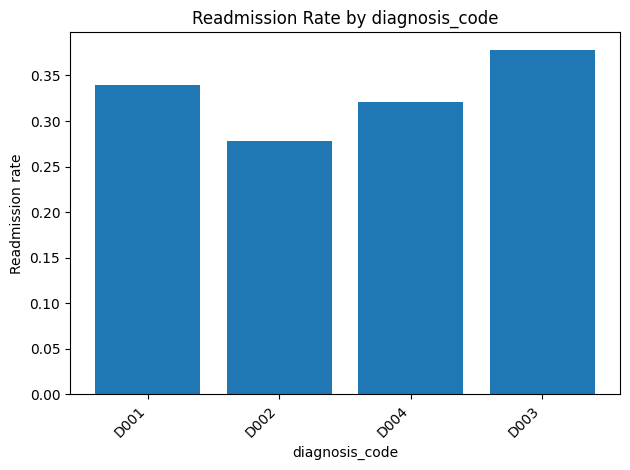

Unique discharge notes: 10
Note: Since unique notes are very low vs rows, notes are likely templated/repeated.


In [13]:
# This section is for data cleaning, exploration, and analysis

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



#Load in the data
df = pd.read_excel('Assignment_Data 1 (1).xlsx')

df.columns = [c.strip() for c in df.columns]

TARGET_COL = "readmitted_30_days"
TEXT_COL = "discharge_note"



# Basic checks
print("Shape (rows, cols):", df.shape)
print("Columns:", df.columns.tolist())

print("\nNumber of Missing Values:")
print(df.isna().sum())

if "patient_id" in df.columns:
    print("\nMake sure patient_id are actually unique:")
    print("Unique patient_id:", df["patient_id"].nunique(dropna=False))
    print("Total rows:", len(df))


# Target distribution
print("\nTarget distribution")
target_counts = df[TARGET_COL].value_counts().sort_index()
print(target_counts)
if pd.api.types.is_numeric_dtype(df[TARGET_COL]):
    rate = df[TARGET_COL].mean()
    print(f"Readmission rate: {rate:.4f} ({rate*100:.2f}%)")

plt.figure()
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target Distribution: readmitted_30_days")
plt.xlabel("readmitted_30_days")
plt.ylabel("Count")
plt.show()




# Summary of columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_predictors = [c for c in numeric_cols if c not in [TARGET_COL]]

print("\nNumeric Columns summary:")
print(df[num_predictors + [TARGET_COL]].describe().T)

# Histograms for age and length_of_stay
for col in ["age", "length_of_stay"]:
    if col in df.columns:
        plt.figure()
        plt.hist(df[col].dropna(), bins=15)
        plt.title(f"Histogram: {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

# Boxplot for length_of_stay
if "length_of_stay" in df.columns and df[TARGET_COL].nunique() == 2:
    plt.figure()
    grouped = [df.loc[df[TARGET_COL] == k, "length_of_stay"].dropna() for k in sorted(df[TARGET_COL].unique())]
    plt.boxplot(grouped, labels=[f"{TARGET_COL}={k}" for k in sorted(df[TARGET_COL].unique())])
    plt.title("length_of_stay by readmission label")
    plt.ylabel("length_of_stay")
    plt.show()



# Categorical columns counts
def plot_readmission_rate_by_category(feature, top_n=None):
    tmp = df.groupby(feature)[TARGET_COL].agg(["count", "mean"]).rename(columns={"mean": "readmission_rate"})
    tmp = tmp.sort_values("count", ascending=False)

    if top_n is not None:
        tmp = tmp.head(top_n)

    print(f"\n{feature}: Value Counts")
    print(df[feature].value_counts(dropna=False))

    print(f"\n{feature}: Readmission Rate")
    tmp_out = tmp.copy()
    tmp_out["readmission_rate_pct"] = (tmp_out["readmission_rate"] * 100).round(2)
    print(tmp_out)

    plt.figure()
    plt.bar(tmp.index.astype(str), tmp["readmission_rate"])
    plt.title(f"Readmission Rate by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Readmission rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Counts for the key categoricals
for col in ["diagnosis_code", "medication_type"]:
    if col in df.columns:
        print(f"\n{col}: Value Counts")
        print(df[col].value_counts(dropna=False))

# Plot readmission rate by diagnosis_code
if "diagnosis_code" in df.columns:
    plot_readmission_rate_by_category("diagnosis_code")
elif "medication_type" in df.columns:
    plot_readmission_rate_by_category("medication_type")


# Check if discharge note repeated
if TEXT_COL:
    unique_notes = df[TEXT_COL].fillna("").astype(str).nunique()
    print("Unique discharge notes:", unique_notes)
    print("Note: Since unique notes are very low vs rows, notes are likely templated/repeated.")

In [16]:
# Feature Engineering and Data Preprocessing

# Creating a few simple features that might help readmission models
df_fe = df.copy()

df_fe["age_group"] = pd.cut(
    df_fe["age"],
    bins=[0, 34, 49, 64, 120],
    labels=["<35", "35-49", "50-64", "65+"],
    include_lowest=True
)

df_fe["prior_adm_any"] = (df_fe["num_previous_admissions"] > 0).astype(int)
df_fe["los_long"] = (df_fe["length_of_stay"] >= 8).astype(int)

df_fe[["age", "age_group", "num_previous_admissions", "prior_adm_any", "length_of_stay", "los_long"]].head()




# Prepare X/y training data
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

TARGET_COL = "readmitted_30_days"

y = df_fe[TARGET_COL]
X = df_fe.drop(columns=["patient_id", "discharge_note", TARGET_COL])

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing step (numeric scaling and categorical one-hot)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

X_train_t = preprocess.fit_transform(X_train)
X_test_t = preprocess.transform(X_test)

print("Raw X_train shape:", X_train.shape)
print("Transformed X_train shape:", X_train_t.shape)
print("Transformed X_test shape:", X_test_t.shape)
print("y_train distribution:", y_train.value_counts().to_dict())
print("y_test distribution:", y_test.value_counts().to_dict())


Raw X_train shape: (160, 9)
Transformed X_train shape: (160, 18)
Transformed X_test shape: (40, 18)
y_train distribution: {0: 108, 1: 52}
y_test distribution: {0: 27, 1: 13}


In [19]:
# Model Training and Evaluation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

# Train model
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=37
)

log_reg.fit(X_train_t, y_train)

# Predictions and predicted probabilities
y_pred = log_reg.predict(X_test_t)
y_proba = log_reg.predict_proba(X_test_t)[:, 1]




# Evaluation metrics
roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"F1-score: {f1:.3f}")
print("Confusion Matrix:")
print(cm)


# Inspect which features influence the prediction
ohe = preprocess.named_transformers_["cat"]

final_feature_names = (
    num_cols
    + ohe.get_feature_names_out(cat_cols).tolist()
)
coefficients = log_reg.coef_[0]
print("\nFeature Importance:\n")
feature_importance = pd.DataFrame({
    "feature": final_feature_names,
    "coefficient": coefficients
}).sort_values("coefficient", ascending=False)

feature_importance.head(10), feature_importance.tail(10)



ROC AUC: 0.422
F1-score: 0.400
Confusion Matrix:
[[12 15]
 [ 6  7]]

Feature Importance:



(                    feature  coefficient
 16            age_group_65+     0.794428
 9       diagnosis_code_D003     0.570041
 13   medication_type_Type C     0.425920
 6               gender_Male     0.362989
 2            length_of_stay     0.353050
 17            age_group_<35     0.247985
 10      diagnosis_code_D004     0.083375
 1   num_previous_admissions     0.053374
 4                  los_long     0.005438
 12   medication_type_Type B    -0.182866,
                    feature  coefficient
 4                 los_long     0.005438
 12  medication_type_Type B    -0.182866
 11  medication_type_Type A    -0.242979
 15         age_group_50-64    -0.277834
 7      diagnosis_code_D001    -0.283260
 5            gender_Female    -0.362915
 8      diagnosis_code_D002    -0.370082
 0                      age    -0.524359
 3            prior_adm_any    -0.622832
 14         age_group_35-49    -0.764505)

### Feature Influence and Interpretation

The logistic regression model highlights several features that were most influential in predicting 30-day hospital readmission. The strongest positive association with readmission was observed for patients aged 65 and older, indicating that older age is an important risk factor in this dataset. Diagnosis code D003 and Medication Type C were also associated with higher readmission risk, which may reflect greater clinical severity or more complex treatment needs at discharge. Longer length of stay and male gender showed smaller but still positive contributions, suggesting that hospitalization complexity and certain demographic factors play a role in post-discharge outcomes.

In contrast, younger age groups (35–49 and 50–64) were associated with a lower likelihood of readmission, as were patients without prior admissions. Diagnosis code D002 and Medication Type A were also linked to reduced readmission risk, potentially representing more stable clinical conditions or less intensive care pathways.

Overall, the most influential features align with clinically intuitive risk factors such as age, diagnosis category, medication complexity, and hospitalization characteristics. However, model performance was modest, indicating that readmission risk is likely influenced by additional factors not captured in the structured data, such as social support, outpatient follow-up, and broader health history.


In [21]:
# Question 2

import pandas as pd
import spacy

nlp = spacy.load("en_core_web_sm")


# Run NER on discharge notes and store extracted entities in a simple structured format
def extract_spacy_entities(text: str):
    doc = nlp(str(text))
    return [
        {"text": ent.text, "label": ent.label_, "start_char": ent.start_char, "end_char": ent.end_char}
        for ent in doc.ents
    ]

df_nlp = df.copy()
df_nlp["entities_spacy"] = df_nlp["discharge_note"].apply(extract_spacy_entities)


df_nlp[["patient_id", "discharge_note", "entities_spacy"]]


,patient_id,discharge_note,entities_spacy
0,1,Good recovery trajectory. Follow-up scan sched...,"[{'text': 'scan', 'label': 'NORP', 'start_char..."
1,2,Stable post-surgery. Advised to avoid physical...,[]
2,3,Symptoms controlled. Monitoring for relapse ad...,[]
3,4,Stable post-surgery. Advised to avoid physical...,[]
4,5,Stable post-surgery. Advised to avoid physical...,[]
...,...,...,...
195,196,Good recovery trajectory. Follow-up scan sched...,"[{'text': 'scan', 'label': 'NORP', 'start_char..."
196,197,Patient discharged with minor discomfort. Advi...,[]
197,198,Discharge after recovery from pneumonia. No co...,[]
198,199,Blood pressure under control. Continue current...,[]


In [34]:
# Use different model due to previous model's incompetence

import stanza, pandas as pd
stanza.download("en")

# Clinical NER model
nlp = stanza.Pipeline(lang="en", processors="tokenize,ner", package={"ner": "i2b2"})

def extract_stanza_entities(text: str):
    doc = nlp(str(text))
    ents = []
    for e in doc.ents:
        ents.append({"text": e.text, "label": e.type})
    return ents

df_nlp = df.copy()
df_nlp["entities_stanza"] = df_nlp["discharge_note"].apply(extract_stanza_entities)
df_nlp[["patient_id","discharge_note","entities_stanza"]].head(25)


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| ner       | i2b2     |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


,patient_id,discharge_note,entities_stanza
0,1,Good recovery trajectory. Follow-up scan sched...,"[{'text': 'Follow-up scan', 'label': 'TEST'}]"
1,2,Stable post-surgery. Advised to avoid physical...,"[{'text': 'surgery', 'label': 'TREATMENT'}]"
2,3,Symptoms controlled. Monitoring for relapse ad...,"[{'text': 'Symptoms', 'label': 'PROBLEM'}, {'t..."
3,4,Stable post-surgery. Advised to avoid physical...,"[{'text': 'surgery', 'label': 'TREATMENT'}]"
4,5,Stable post-surgery. Advised to avoid physical...,"[{'text': 'surgery', 'label': 'TREATMENT'}]"
5,6,Good recovery trajectory. Follow-up scan sched...,"[{'text': 'Follow-up scan', 'label': 'TEST'}]"
6,7,Discharge after recovery from pneumonia. No co...,"[{'text': 'pneumonia', 'label': 'PROBLEM'}, {'..."
7,8,Patient discharged in stable condition. Recomm...,[]
8,9,Patient showed improvement. Prescribed antibio...,"[{'text': 'antibiotics', 'label': 'TREATMENT'}]"
9,10,Blood pressure under control. Continue current...,"[{'text': 'Blood pressure', 'label': 'TEST'}, ..."


In [ ]:
import json

from google.colab import drive
drive.mount('/content/drive')
in_path = "/content/drive/MyDrive/Colab Notebooks/DataScientistAssignment.ipynb"
out_path = "/content/drive/MyDrive/Colab Notebooks/DataScientistAssignment_github.ipynb"


with open(in_path, "r", encoding="utf-8") as f:
    nb = json.load(f)

# 1) Remove widgets metadata (this is what triggers the error)
nb.get("metadata", {}).pop("widgets", None)

# 2) Remove widget outputs only (keep normal outputs)
for cell in nb.get("cells", []):
    if cell.get("cell_type") != "code":
        continue
    new_outputs = []
    for out in cell.get("outputs", []):
        data = out.get("data", {})
        # Drop widget views (these require widget state to render)
        if "application/vnd.jupyter.widget-view+json" in data:
            continue
        new_outputs.append(out)
    cell["outputs"] = new_outputs

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print("Saved:", out_path)


### Model Used
I initally used the spacy model, but given the lack of meaningful results, I decided to pivot and use a model that is trained on clinical text and is designed to recognize healthcare-specific concepts rather than general named entities.. Thus, I used the NER model Stanza i2b2-style to extract medically relevant entities from short discharge notes. The model successfully identified and labeled the following categories across the discharge notes: Diagnoses/Problems, Treatments/Medications, Procedures/Tests, and Follow-up Actions and Instructions.

### Optional Use of LLMs and Prompt Engineering
Although a clinical NLP NER model was sufficient for this task, an open-source instruction-tuned LLM (like Flan-T5) could optionally be used with prompt engineering to guide consistent structured extraction. By constraining the model to output predefined fields such as diagnoses, medications, procedures, and follow-up actions in a JSON format, prompt engineering can improve consistency across notes. However, this approach trades interpretability and determinism for flexibility and is not strictly necessary when a domain-specific clinical NLP model is available.

### Risks and Limitations
Clinical entity extraction is subject to several limitations. Some medical concepts are implicit rather than explicitly stated (e.g., “post-surgery” without naming the procedure), which can reduce extraction granularity. General-purpose language models may hallucinate entities that are not present in the text, especially when notes are short or vague. Even clinical NLP models depend on surface-level wording and may miss nuanced context. Additionally, extracted entities are not clinically validated and should not be used for medical decision-making without human review.

### Conclusion
Applying a clinical NLP NER model enabled reliable extraction of diagnoses, treatments, tests, and follow-up-related actions from discharge notes, significantly outperforming general-purpose NER approaches. This method provides structured clinical insight while avoiding the hallucination risks associated with LLM-based extraction, making it well-suited for analyzing short, templated clinical documentation.
